In [1]:
import tensorflow as tf
from keras.src import backend
from keras.src import constraints
from keras.src import initializers
from keras.src import regularizers
from keras.src.engine import base_layer_utils
from keras.src.engine.base_layer import Layer
import numpy as np
from tensorflow.keras.utils import plot_model


In [70]:

class Custome_Embedding(Layer):
    def __init__(
            self,
            input_dim,
            output_dim,
            embeddings_initializer="uniform",
            embeddings_regularizer=None,
            activity_regularizer=None,
            embeddings_constraint=None,
            mask_zero=False,
            input_length=None,
            sparse=False,
            **kwargs,
    ):
        if "input_shape" not in kwargs:
            if input_length:
                kwargs["input_shape"] = (input_length,)
            else:
                kwargs["input_shape"] = (None,)
        if input_dim <= 0 or output_dim <= 0:
            raise ValueError(
                "Both `input_dim` and `output_dim` should be positive, "
                f"Received input_dim = {input_dim} "
                f"and output_dim = {output_dim}"
            )
        if (
                not base_layer_utils.v2_dtype_behavior_enabled()
                and "dtype" not in kwargs
        ):
            # In TF1, the dtype defaults to the input dtype which is typically
            # int32, so explicitly set it to floatx
            kwargs["dtype"] = backend.floatx()
        # We set autocast to False, as we do not want to cast floating- point
        # inputs to self.dtype. In call(), we cast to int32, and casting to
        # self.dtype before casting to int32 might cause the int32 values to be
        # different due to a loss of precision.
        kwargs["autocast"] = False
        use_one_hot_matmul = kwargs.pop("use_one_hot_matmul", False)
        super().__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.embeddings_initializer = initializers.get(embeddings_initializer)
        self.embeddings_regularizer = regularizers.get(embeddings_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.embeddings_constraint = constraints.get(embeddings_constraint)
        self.mask_zero = mask_zero
        self.supports_masking = mask_zero
        self.input_length = input_length
        self.sparse = sparse
        if self.sparse and self.mask_zero:
            raise ValueError(
                "`mask_zero` cannot be enabled when "
                "`tf.keras.layers.Embedding` is used with `tf.SparseTensor` "
                "input."
            )
        # Make this flag private and do not serialize it for now.
        # It will be part of the public API after further testing.
        self._use_one_hot_matmul = use_one_hot_matmul

    def build(self, input_shape=None):
        self.zero_vector = tf.constant(0.0, shape=(1, self.output_dim))
        self.built = True

        self.embeddings = self.add_weight(
            shape=(self.input_dim - 1, self.output_dim),
            initializer=self.embeddings_initializer,
            name="embeddings",
            regularizer=self.embeddings_regularizer,
            constraint=self.embeddings_constraint,
            experimental_autocast=False,
        )

    def get_embeddings(self):
        return tf.concat([self.zero_vector, self.embeddings], axis=0).numpy()

    def call(self, inputs):
        full_embeddings = tf.concat([self.zero_vector, self.embeddings], axis=0)
        dtype = backend.dtype(inputs)
        if dtype != "int32" and dtype != "int64":
            inputs = tf.cast(inputs, "int32")
        if isinstance(inputs, tf.sparse.SparseTensor):
            if self.sparse:
                # get sparse embedding values
                embedding_values = tf.nn.embedding_lookup(
                    params=full_embeddings, ids=inputs.values
                )
                embedding_values = tf.reshape(embedding_values, [-1])
                # get sparse embedding indices
                indices_values_embed_axis = tf.range(self.output_dim)
                repeat_times = [inputs.indices.shape[0]]
                indices_values_embed_axis = tf.expand_dims(
                    tf.tile(indices_values_embed_axis, repeat_times), -1
                )
                indices_values_embed_axis = tf.cast(
                    indices_values_embed_axis, dtype=tf.int64
                )
                current_indices = tf.repeat(
                    inputs.indices, [self.output_dim], axis=0
                )
                new_indices = tf.concat(
                    [current_indices, indices_values_embed_axis], 1
                )
                new_shape = tf.concat(
                    [tf.cast(inputs.shape, dtype=tf.int64), [self.output_dim]],
                    axis=-1,
                )
                out = tf.SparseTensor(
                    indices=new_indices,
                    values=embedding_values,
                    dense_shape=new_shape,
                )
            else:
                sparse_inputs_expanded = tf.sparse.expand_dims(inputs, axis=-1)
                out = tf.nn.safe_embedding_lookup_sparse(
                    embedding_weights=full_embeddings,
                    sparse_ids=sparse_inputs_expanded,
                    default_id=0,
                )
        elif self._use_one_hot_matmul:
            # Note that we change the dtype of the one_hot to be same as the
            # weight tensor, since the input data are usually ints, and weights
            # are floats. The nn.embedding_lookup support ids as ints, but
            # the one_hot matmul need both inputs and weights to be same dtype.
            one_hot_data = tf.one_hot(
                inputs, depth=self.input_dim, dtype=self.dtype
            )
            out = tf.matmul(one_hot_data, full_embeddings)
        else:

            out = tf.nn.embedding_lookup(full_embeddings, inputs)

        if self.sparse and not isinstance(out, tf.SparseTensor):
            out = tf.sparse.from_dense(out)

        if (
                self._dtype_policy.compute_dtype
                != self._dtype_policy.variable_dtype
        ):
            # Instead of casting the variable as in most layers, cast the
            # output, as this is mathematically equivalent but is faster.
            out = tf.cast(out, self._dtype_policy.compute_dtype)
        return out

    def get_config(self):
        config = {
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "embeddings_initializer": initializers.serialize(
                self.embeddings_initializer
            ),
            "embeddings_regularizer": regularizers.serialize(
                self.embeddings_regularizer
            ),
            "activity_regularizer": regularizers.serialize(
                self.activity_regularizer
            ),
            "embeddings_constraint": constraints.serialize(
                self.embeddings_constraint
            ),
            "mask_zero": self.mask_zero,
            "input_length": self.input_length,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))




Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custome__embedding (Custom  (None, None, 3)           27        
 e_Embedding)                                                    
                                                                 
 lstm_17 (LSTM)              (None, 4)                 112       
                                                                 
 dense_10 (Dense)            (None, 1)                 4         
                                                                 
Total params: 143 (572.00 Byte)
Trainable params: 27 (108.00 Byte)
Non-trainable params: 116 (464.00 Byte)
_________________________________________________________________
None


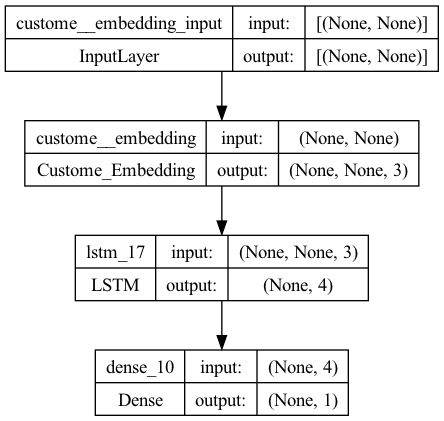

In [71]:
model = tf.keras.Sequential()

# emb_layer = tf.keras.layers.Embedding(10, 3, input_length=10)
emb_layer = Custome_Embedding(10, 3)
model.add(emb_layer)
# model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.LSTM(units=4, use_bias=False))
model.add(tf.keras.layers.Dense(1, use_bias=False))
model.compile(optimizer='adam', loss='binary_crossentropy')

# Freeze the LSTM and Dense layer
model.layers[1].trainable = False
model.layers[2].trainable = False
print(model.summary())
plot_model(model, show_shapes=True)

In [72]:
# Access the weights of the embedding layer
embedding_weights = model.layers[0].get_embeddings()
print(embedding_weights)

# Generate fake data
x = np.random.randint(10, size=(64, 10))
y = np.random.randint(2, size=(64, 1))
# # Train model
model.fit(x, y, epochs=2000, verbose=0, batch_size=16)

# Access the weights of the embedding layer
embedding_weights = model.layers[0].get_embeddings()
print(embedding_weights)

x1 = np.random.randint(1, 10, size=(1, 10))
print(x1)
print(model.predict(x1))
x2 = np.array([np.concatenate(([0, 0, 0, 0], x1[0]))])
print(x2)
print(model.predict(x2))
x3 = np.array([np.concatenate(([0]*200, x1[0]))])
print(x3)
print(model.predict(x3))


[[ 0.          0.          0.        ]
 [-0.00801094  0.03378465 -0.04560906]
 [ 0.04524237  0.01626882 -0.03660771]
 [-0.0086177   0.00789385  0.03121673]
 [-0.02142623  0.006064   -0.04531957]
 [ 0.03141249 -0.03275862 -0.02705331]
 [ 0.03150919 -0.01477723  0.02085194]
 [ 0.0116315  -0.04825673 -0.03060819]
 [ 0.03371381  0.01047663  0.02313927]
 [-0.02215341  0.02515152  0.03962693]]
[[ 0.          0.          0.        ]
 [ 0.16197674 -0.10768304 -0.7651424 ]
 [ 0.20169066 -0.05423929 -0.54271996]
 [ 0.20620218  0.00245596 -0.10089633]
 [-0.6317413  -0.61734456 -0.31391674]
 [-0.01612154  0.04548636  0.15419038]
 [ 0.09661341  0.00801838  0.06509939]
 [-0.7683154  -0.5082582   0.0227467 ]
 [ 0.463658   -0.01659281 -0.46282667]
 [ 0.19780158  0.2272086  -0.22232996]]
[[7 4 3 3 2 8 5 3 6 4]]
1/1 [==============================] - 0s 47ms/step
[[2.5440273]]
[[0 0 0 0 7 4 3 3 2 8 5 3 6 4]]
1/1 [==============================] - 0s 47ms/step
[[2.5440273]]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [60]:
print(emb_layer(x1))
print(emb_layer(x2))
print(emb_layer(x3))


tf.Tensor(
[[[-0.04572376 -0.335217    0.34597567]
  [-0.206415    0.44539708 -0.53672534]
  [-0.41013697  0.0585303  -0.12989931]
  [ 0.4606962   0.31861994 -0.42341158]
  [ 0.21150026 -0.33698097  0.04082778]
  [ 0.60667217  0.36055258 -0.11214168]
  [-0.41013697  0.0585303  -0.12989931]
  [-0.206415    0.44539708 -0.53672534]
  [-0.206415    0.44539708 -0.53672534]
  [-0.04572376 -0.335217    0.34597567]]], shape=(1, 10, 3), dtype=float32)
tf.Tensor(
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-0.04572376 -0.335217    0.34597567]
  [-0.206415    0.44539708 -0.53672534]
  [-0.41013697  0.0585303  -0.12989931]
  [ 0.4606962   0.31861994 -0.42341158]
  [ 0.21150026 -0.33698097  0.04082778]
  [ 0.60667217  0.36055258 -0.11214168]
  [-0.41013697  0.0585303  -0.12989931]
  [-0.206415    0.44539708 -0.53672534]
  [-0.206415    0.44539708 -0.53672534]
  [-0.04572376 -0.3352

In [73]:
inputs = tf.random.normal([1, 10, 3])
print(inputs)
# lstm = tf.keras.layers.LSTM(4)
lstm = model.layers[1]
output = lstm(inputs)
print(output)
inputs = tf.concat([tf.zeros([1, 2, 3]), inputs], axis=1)
print(inputs)
output = lstm(inputs)
print(output)
inputs = tf.concat([tf.zeros([1, 20, 3]), inputs], axis=1)
print(inputs)
output = lstm(inputs)
print(output)
inputs =tf.zeros([1, 5, 3])
print(inputs)
output = lstm(inputs)
print(output)
inputs =tf.zeros([1, 20, 3])
print(inputs)
output = lstm(inputs)
print(output)


tf.Tensor(
[[[-1.0813093  -0.4893329  -0.62319666]
  [-1.6976321   1.0189859   0.02154098]
  [ 1.2313883  -1.4080871   0.20486924]
  [-0.74894595  0.550059    0.45649034]
  [-0.8965127   0.0870026  -0.6504864 ]
  [-1.1346627   0.01559364 -0.4585714 ]
  [-2.135648    1.4435581  -1.5973858 ]
  [ 1.5465449   1.0052935   1.0285333 ]
  [-0.02827742  0.91486883 -0.23544593]
  [ 0.24502678  0.34319794  0.840755  ]]], shape=(1, 10, 3), dtype=float32)
tf.Tensor([[0.11434755 0.1288884  0.01264075 0.0209043 ]], shape=(1, 4), dtype=float32)
tf.Tensor(
[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [-1.0813093  -0.4893329  -0.62319666]
  [-1.6976321   1.0189859   0.02154098]
  [ 1.2313883  -1.4080871   0.20486924]
  [-0.74894595  0.550059    0.45649034]
  [-0.8965127   0.0870026  -0.6504864 ]
  [-1.1346627   0.01559364 -0.4585714 ]
  [-2.135648    1.4435581  -1.5973858 ]
  [ 1.5465449   1.0052935   1.0285333 ]
  [-0.02827742  0.91486883 -0.23544593]
  [ 0.24502678